##Logistic Regression Model

In [ ]:
%pip install polars
%pip install pyarrow

In [16]:
#import necessary libraries
import sys
import pyarrow
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from matplotlib import cm
import numpy as np
import polars as pl
import pandas as pd
from glob import glob
from sklearn.impute import SimpleImputer
# Append the directory containing `merge_tools.py` to the Python path
sys.path.append('../notebooks/utils/')

In [17]:
# Importing functions from merge_tools.py
def merge_n_case_ids(
    n_ids: int = 10000,
    data_dir: str = '/kaggle/input/cr-newagg/new_aggs',
    path_to_base: str = '/kaggle/input/datasets-cr/train_base.parquet',
    use_0: bool = True,
    as_pandas: bool = True,
    random_state: int = 28
) -> pl.DataFrame | pd.DataFrame:
    '''
    Function to merge selected case_id from parquet files, returns subset case_id from the merged dataset.

    Parameters
    ----------
    n_ids : Number of case_ids to sample initially and return (int)
    data_dir : Path to processed parquet files directory (str)
    path_to_base : Path to base file (str)
    use_0 : Use num_group1 == 0 (bool)
    as_pandas : Return as pandas DataFrame
    random_seed : Random seed (int)
    '''
    # Read the base dataframe and sample case_ids
    if as_pandas:
        base_df = pd.read_parquet(path_to_base)
        case_ids = base_df['case_id'].sample(n=n_ids, replace=False, random_state=random_state).tolist()
    else:
        base_df = pl.read_parquet(path_to_base)
        case_ids = base_df['case_id'].sample(n=n_ids, replace=False, seed=random_state).to_list()

    # Define the file pattern for fetching files
    file_pattern = '*grouped_0.parquet' if use_0 else '*grouped_rest.parquet'
    file_paths = glob(data_dir + '/' + file_pattern)

    # Initialize the merged DataFrame filtering the base DataFrame
    if as_pandas:
        df = base_df[base_df['case_id'].isin(case_ids)]
    else:
        df = base_df.filter(pl.col('case_id').is_in(case_ids))

    # Merge DataFrames with only the selected case_ids
    for path in file_paths:
        if as_pandas:
            temp = pd.read_parquet(path)
            temp = temp[temp['case_id'].isin(case_ids)]
            df = pd.merge(df, temp, on='case_id', how='outer')
        else:
            temp = pl.read_parquet(path)
            temp = temp.filter(pl.col('case_id').is_in(case_ids))
            df = df.join(temp, on='case_id', how='outer')

    # Convert to pandas if required and using Polars
    if as_pandas and isinstance(df, pl.DataFrame):
        df = df.to_pandas()

    return df

In [18]:
# Setting up the file paths and parameters
base_path = '../data/raw/parquet_files/train/train_base.parquet'
data_dir = '../data/processed/grouped/new_aggs/'

# Choose parameters
n_ids = 30000  # let's start by processing only 30000 case_ids
use_0 = True  
as_pandas = True  # Return result as pandas DataFrame
random_state=28 


In [19]:
# Merge data function
merged_data = merge_n_case_ids(
    n_ids=n_ids, 
    data_dir=data_dir, 
    path_to_base=base_path, 
    use_0=use_0, 
    as_pandas=as_pandas)


In [20]:
merged_data

,case_id,date_decision,MONTH,WEEK_NUM,target,empls_employedfrom_796D_distinct,empls_employedfrom_796D_min_year,empls_employedfrom_796D_min_month,empls_employedfrom_796D_min_day,empls_employedfrom_796D_max_year,...,amtdebitincoming_4809443A_median,amtdebitoutgoing_4809440A_median,amtdepositbalance_4809441A_median,amtdepositincoming_4809444A_median,amtdepositoutgoing_4809442A_median,amtdebitincoming_4809443A_sum,amtdebitoutgoing_4809440A_sum,amtdepositbalance_4809441A_sum,amtdepositincoming_4809444A_sum,amtdepositoutgoing_4809442A_sum
0,4,2019-01-04,201901,0,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,33,2019-01-03,201901,0,0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,62,2019-01-03,201901,0,0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,128,2019-01-07,201901,0,0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,134,2019-01-04,201901,0,0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,2703286,2020-10-05,202010,91,0,1.0,NaN,NaN,NaN,NaN,...,20000.0,20000.0,0.0000,0.0,0.0,20000.0,20000.0,0.0000,0.0,0.0
29996,2703347,2020-10-05,202010,91,0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29997,2703348,2020-10-05,202010,91,0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29998,2703350,2020-10-05,202010,91,0,1.0,NaN,NaN,NaN,NaN,...,0.0,0.0,4442.8003,0.0,35.8,0.0,0.0,4442.8003,0.0,35.8


In [21]:
# Converting 'date_decision' from object to 'datetime64'
merged_data['date_decision'] = pd.to_datetime(merged_data['date_decision'])

# Extract day, month, and year into separate columns with specific names
merged_data['date_decision_year'] = merged_data['date_decision'].dt.year
merged_data['date_decision_month'] = merged_data['date_decision'].dt.month
merged_data['date_decision_day'] = merged_data['date_decision'].dt.day

# Display the DataFrame to see the changes
print(merged_data)

       case_id date_decision   MONTH  WEEK_NUM  target  \
0            4    2019-01-04  201901         0       1   
1           33    2019-01-03  201901         0       0   
2           62    2019-01-03  201901         0       0   
3          128    2019-01-07  201901         0       0   
4          134    2019-01-04  201901         0       0   
...        ...           ...     ...       ...     ...   
29995  2703286    2020-10-05  202010        91       0   
29996  2703347    2020-10-05  202010        91       0   
29997  2703348    2020-10-05  202010        91       0   
29998  2703350    2020-10-05  202010        91       0   
29999  2703352    2020-10-05  202010        91       0   

       empls_employedfrom_796D_distinct  empls_employedfrom_796D_min_year  \
0                                   NaN                               NaN   
1                                   1.0                               NaN   
2                                   1.0                               Na

In [23]:
merged_data.drop(columns='date_decision', inplace=True)

In [24]:
#This approach is particularly useful if we suspect that the absence of data could itself be meaningful.
categorical_columns = merged_data.select_dtypes(include=['object', 'category']).columns

categorical_columns

Index(['contaddr_matchlist_1032L_min', 'contaddr_smempladdr_334L_min',
       'isreference_387L_min', 'remitter_829L_min',
       'safeguarantyflag_411L_min', 'contaddr_matchlist_1032L_max',
       'contaddr_smempladdr_334L_max', 'isreference_387L_max',
       'remitter_829L_max', 'safeguarantyflag_411L_max',
       'isbidproduct_390L_min', 'isdebitcard_527L_min',
       'isbidproduct_390L_max', 'isdebitcard_527L_max'],
      dtype='object')

In [25]:
# Drop the object columns from the DataFrame
merged_data.drop(columns=categorical_columns, inplace=True)

# Print the new DataFrame information to confirm columns are deleted
print(merged_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Columns: 1349 entries, case_id to date_decision_day
dtypes: float64(1233), int32(5), int64(4), int8(99), uint32(8)
memory usage: 287.4 MB
None


In [57]:
merged_data 

,case_id,MONTH,WEEK_NUM,target,empls_employedfrom_796D_distinct,empls_employedfrom_796D_min_year,empls_employedfrom_796D_min_month,empls_employedfrom_796D_min_day,empls_employedfrom_796D_max_year,empls_employedfrom_796D_max_month,...,amtdepositincoming_4809444A_median,amtdepositoutgoing_4809442A_median,amtdebitincoming_4809443A_sum,amtdebitoutgoing_4809440A_sum,amtdepositbalance_4809441A_sum,amtdepositincoming_4809444A_sum,amtdepositoutgoing_4809442A_sum,date_decision_year,date_decision_month,date_decision_day
0,4,201901,0,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,1,4
1,33,201901,0,0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,1,3
2,62,201901,0,0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,1,3
3,128,201901,0,0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,1,7
4,134,201901,0,0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,2703286,202010,91,0,1.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,20000.0,20000.0,0.0000,0.0,0.0,2020,10,5
29996,2703347,202010,91,0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,10,5
29997,2703348,202010,91,0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,10,5
29998,2703350,202010,91,0,1.0,NaN,NaN,NaN,NaN,NaN,...,0.0,35.8,0.0,0.0,4442.8003,0.0,35.8,2020,10,5


In [42]:
# Count the occurrences of each unique value in 'target'
X = merged_data.drop('target', axis=1)
y = merged_data['target']

In [58]:
# Create an imputer object using the median strategy for numerical columns
imputer = SimpleImputer(strategy='median')

In [59]:
# Impute missing values in X
X_imputed = imputer.fit_transform(X)
X_imputed = pd.DataFrame(X_imputed, columns=X.columns) 

In [62]:
#Ensuring y does not have any missing values
y = y.dropna()

##Model Building - Logistic Regression

In [63]:
# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_imputed, y, test_size=0.20, random_state=42)

In [64]:
# Scale the features for only numeric columns
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

In [65]:
pipeline = Pipeline([
    ('pca', PCA()),
    ('logistic', LogisticRegression(solver='saga', random_state=42))
])


In [68]:
param_grid = {
    'pca__n_components': [5, 10, 15, 20, 25, 30],  # Number of components to keep
    'logistic__C': [0.001, 0.01, 0.1, 1, 10, 100]  # Regularization strengths
}

In [ ]:
# Grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', verbose=1)
grid_search.fit(X_train, y_train)  


In [70]:
# Predict probabilities on the validation set
y_pred_prob = grid_search.best_estimator_.predict_proba(X_valid_scaled)[:, 1]

# Compute AUC
auc_score = roc_auc_score(y_valid, y_pred_prob)
print(f"Validation AUC: {auc_score:.3f}")

Validation AUC: 0.565


/opt/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


In [71]:
print("Best parameters:", grid_search.best_params_)

Best parameters: {'logistic__C': 10, 'pca__n_components': 30}


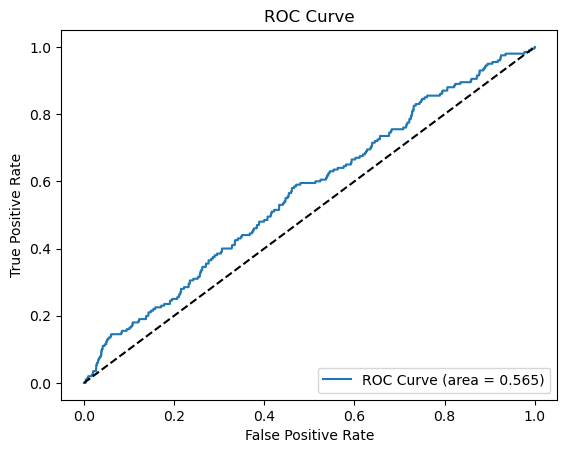

In [72]:
fpr, tpr, thresholds = roc_curve(y_valid, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, label='ROC Curve (area = %0.3f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


/opt/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


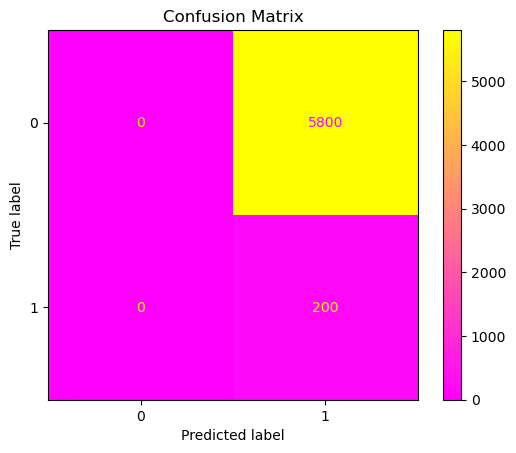

Best parameters found: {'logistic__C': 10, 'pca__n_components': 30}
Accuracy: 3.33%


In [73]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score


# Predict class labels on the validation set
y_pred = grid_search.best_estimator_.predict(X_valid_scaled)

# Generate and display the confusion matrix
cm = confusion_matrix(y_valid, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.spring)  # Changed color map to 'viridis'
plt.title('Confusion Matrix')
plt.show()

# Output the best parameters
print("Best parameters found:", grid_search.best_params_)

# Calculate and print the accuracy
accuracy = accuracy_score(y_valid, y_pred)
print(f"Accuracy: {accuracy:.2%}")  # Printing as a percentage


In [74]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
    title : string, title of the chart
    X : array-like, shape (n_samples, n_features), training vector
    y : array-like, shape (n_samples) or (n_samples, n_features), target values
    ylim : tuple, shape (ymin, ymax), Defines minimum and maximum yvalues plotted
    cv : int, cross-validation generator or an iterable
    n_jobs : int or None, optional (default=None), number of jobs to run in parallel
    train_sizes : array-like, shape (n_ticks,), percentage of training instances to generate learning curve
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring="accuracy")
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


/opt/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.10/site-pack

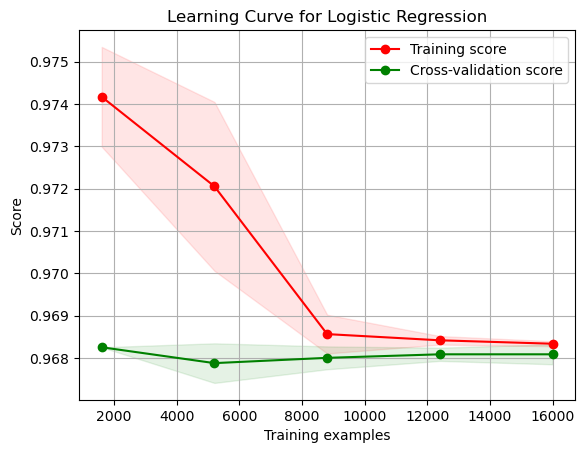

In [75]:
# Use the best estimator from your previous grid search
best_estimator = grid_search.best_estimator_

# Generate the learning curve
plot_learning_curve(estimator=best_estimator, title='Learning Curve for Logistic Regression',
                    X=X_train_scaled, y=y_train, cv=3, n_jobs=-1)

# Show plot
plt.show()
